In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(['seaborn','figsize'])
_SAVEDIR_ = 'Tex/figures/'
from IPython.display import HTML


def prog_bar(cur_val,max_val,msg = ""):
    import sys
    sys.stdout.write('\r')
    eq = int(np.ceil(np.true_divide(cur_val*100,max_val*5)))
    sys.stdout.write("[{:20s}] {}/{} {:}  ".format('='*eq, cur_val+1,max_val,msg))
    sys.stdout.flush()


[====================] 500/500   

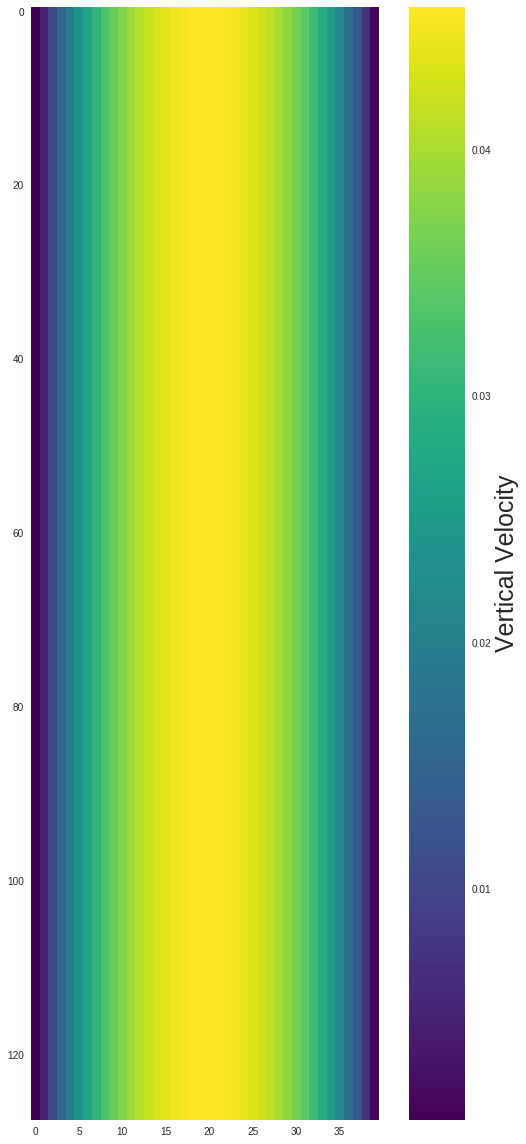

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import numexpr as ne
mpl.style.use([ 'figsize'])


# define constants
lx =128
ly = 40
Nsteps = 2000
ex=[0,1,0,-1,0 ,1,-1,-1, 1]
ey=[0,0,1,0 ,-1,1, 1,-1,-1]
w = [4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36]
G = -5
omega = 1
rho_psi = 1

cs = 1/np.sqrt(3)
cs2  = 1.00 / 3.00
cs22 = 2.00 * cs2
cssq = 2.0 / 9.00
boundaries = np.zeros([lx,ly])
boundaries[:,0] = 1
boundaries[:,-1] = 1
# boundaries[20:25,20:25]=1
opp = [0,3,4,1,2,7,8,5,6]

#plotting functions:
def flip_T(a):
    return np.flipud(a.T)
def calc_macro_f(f):
    #Assumes f at a given time step
    #  this fxn shouldn't be used in the loops as it takes times to create new numpy arrays
    # useful after running for getting macro quantities w/o having the rho,u, and v arrays handy
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])

    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v

# simulation functions
def equilibrium(rho,u,v):
    feq = np.zeros([9,lx,ly])
    usq = u*u
    vsq = v*v
    sumsq = (usq+vsq)/cs22
    sumsq2 = sumsq*(1-cs2)/cs2
    u22 = usq/cssq
    v22 = vsq/cssq
    ui = u/cs2
    vi = v/cs2
    uv = ui*vi
    feq[0] = (4.0/9.0)*rho*(1.00 - sumsq)

    feq[1] = (1.0/9.0)*rho*(1.00 - sumsq + u22 + ui)
    feq[2] = (1.0/9.0)*rho*(1.00 - sumsq + v22 + vi)
    feq[3] = (1.0/9.0)*rho*(1.00 - sumsq + u22 - ui)
    feq[4] = (1.0/9.0)*rho*(1.00 - sumsq + v22 - vi)

    feq[5] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui + vi + uv)
    feq[6] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui + vi - uv)
    feq[7] = (1.0/36.0)*rho*(1.00 + sumsq2 - ui - vi + uv)
    feq[8] = (1.0/36.0)*rho*(1.00 + sumsq2 + ui - vi - uv)
    return feq
def calc_force(rho):
    psi = ne.evaluate('rho_psi*(1-exp(-rho/rho_psi))')
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))-np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

    force_x = -G*(f_x/9+f2_x/36)
    force_y = -G*(f_y/9+f2_y/36)
    return force_x, force_y
def fast(rho, Nsteps,boundaries):
    f = np.zeros([Nsteps, 9,lx,ly])
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])

    for kk in range(0,9):
        f[0,kk,:,:] = w[kk]*rho

    for ts in range(1,Nsteps):
        prog_bar(ts,Nsteps)

        u[:,:] = 0
        v[:,:] = 0

        rho = np.sum(f[ts-1],axis=0)
        for k in range(9):
            u += f[ts-1,k]*ex[k]
            v += f[ts-1,k]*ey[k]
        u=u/rho
        v=v/rho
        u += (10**-4)/rho

        
        f[ts] = equilibrium(rho,u,v)
# prepare the next time step
        fout = f[ts]

        # boundary
        # north & south
        for k in range(0,9):
            fout[k][boundaries == 1] = f[ts,opp[k]][boundaries == 1]
#             fout[k][internal_bound==1]=0
        # streaming
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))
    return f


rho_init = np.ones([lx,ly])
# plt.imshow(flip_T(rho_init))
# plt.colorbar()
# plt.grid('off')
# plt.show()

Nsteps = 500
a = fast(rho_init, Nsteps,boundaries)
rho = calc_macro_f(a[-1])[1]
plt.figure(figsize=(9,16))
plt.imshow(flip_T(rho.T),cmap='viridis')
# plt.colorbar()
cbar = plt.colorbar()
fs = 25
cbar.ax.set_ylabel('Vertical Velocity',fontsize=fs)
plt.grid('off')
plt.tight_layout()
# plt.show()
plt.savefig(_SAVEDIR_+"pois_flow.png")


[====================] 3000/3000   

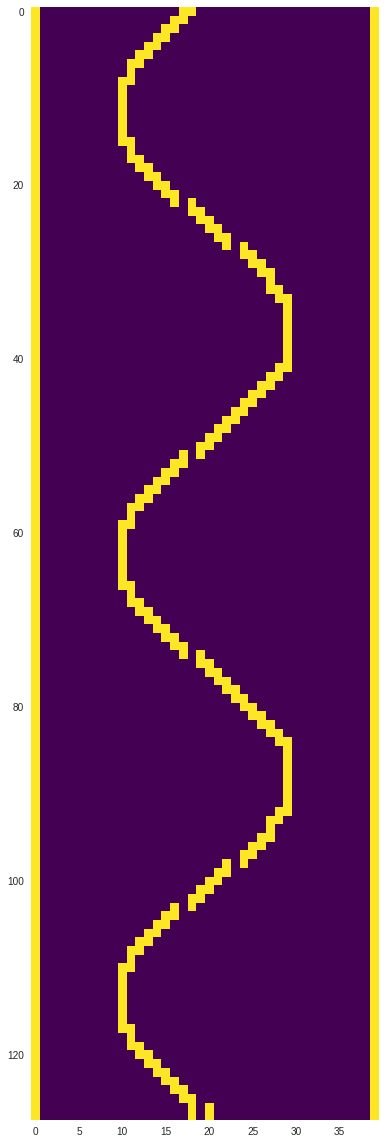

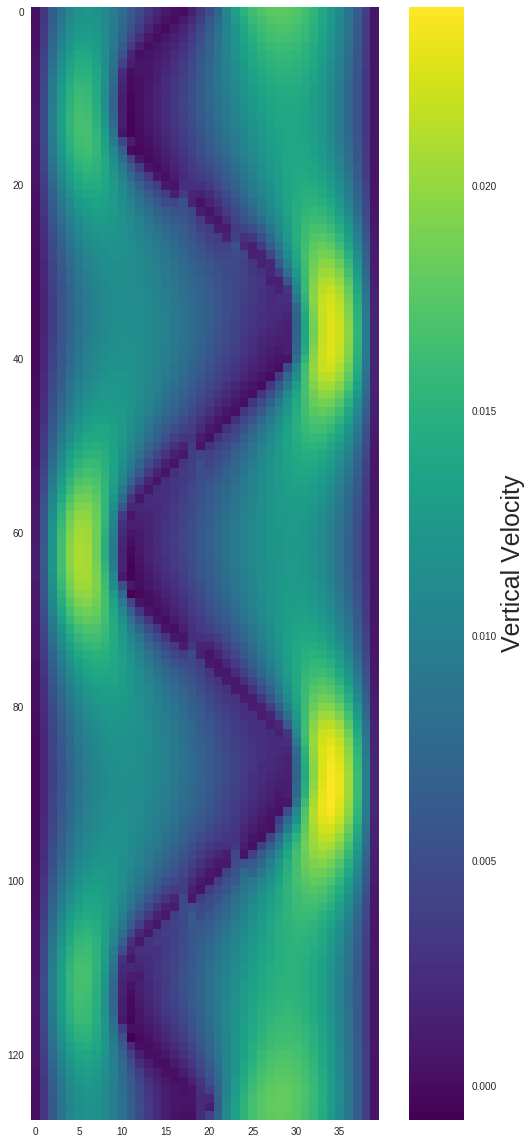

In [25]:
boundaries = np.zeros([lx,ly])
boundaries[:,0] = 1
boundaries[:,-1] = 1
# plt.plot((np.sin(np.arange(0,lx)*np.pi*5/128))*10+ly/2)
for i in np.arange(0,lx):
    y = -np.sin(i*np.pi*5/128)*10+ly/2
    boundaries[i,int(y)]=1
    boundaries[(i+1)%lx,int(y)]=1
plt.figure(figsize=(9,16))
plt.imshow(flip_T(boundaries.T),cmap='viridis')
plt.grid('off')
plt.tight_layout()

plt.savefig(_SAVEDIR_+"sin_boundary.png")
# plt.show()
a = fast(rho_init, 3000,boundaries)
rho = calc_macro_f(a[-1])[1]
plt.figure(figsize=(9,16))
plt.imshow(flip_T(rho.T),cmap='viridis')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Vertical Velocity',fontsize=25)
plt.grid('off')
plt.tight_layout()

plt.savefig(_SAVEDIR_+"sin_boundary_result.png")


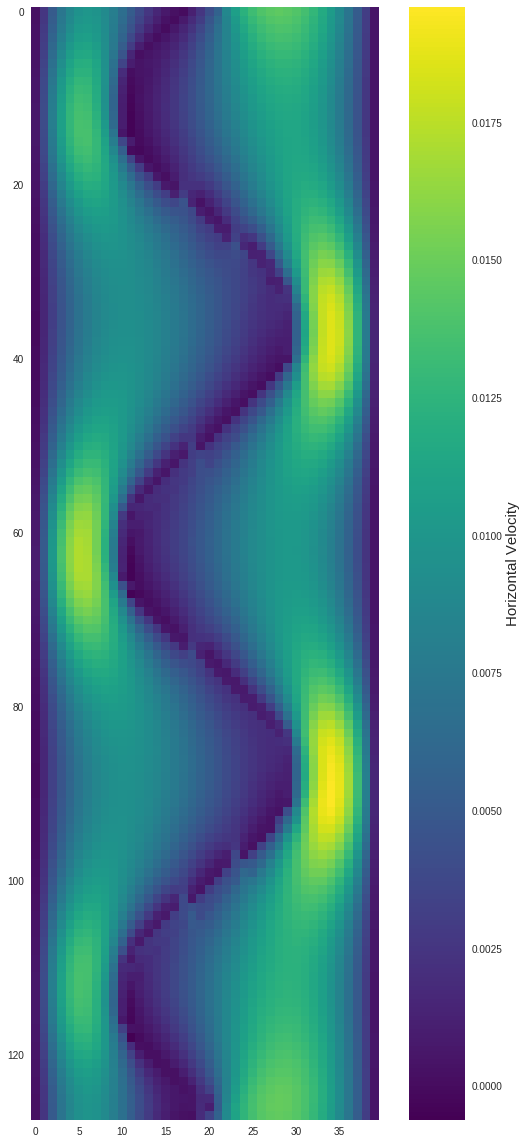

In [17]:
rho = calc_macro_f(a[-1])[1]
plt.figure(figsize=(9,16))
plt.imshow(flip_T(rho.T),cmap='viridis')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Horizontal Velocity',fontsize=fs)
plt.grid('off')
plt.tight_layout()

plt.savefig(_SAVEDIR_+"sin_boundary_result.png")


[====================] 1000/1000   

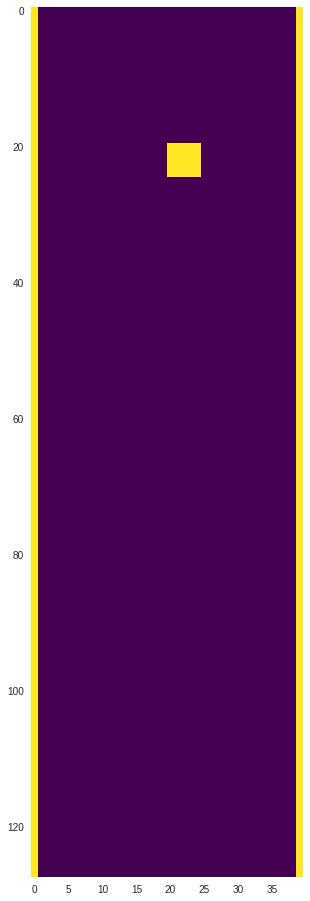

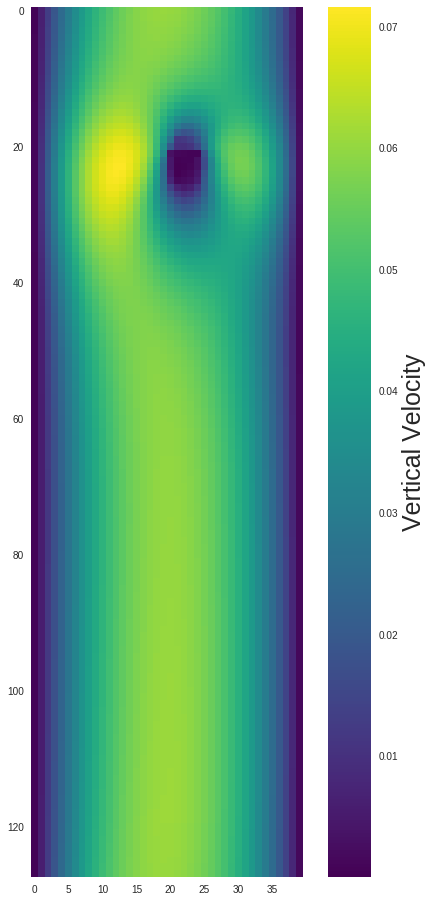

In [32]:
boundaries = np.zeros([lx,ly])
boundaries[:,0] = 1
boundaries[:,-1] = 1
boundaries[20:25,20:25]=1
plt.figure(figsize=(9,16))
plt.imshow(boundaries,cmap='viridis')
plt.grid('off')
plt.savefig(_SAVEDIR_+"box_boundary.png")
# plt.show()
a = fast(rho_init, 1000,boundaries)
rho = calc_macro_f(a[-1])[1]
plt.figure(figsize=(9,16))
plt.imshow(rho,cmap='viridis')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Vertical Velocity',fontsize=fs)
plt.grid('off')
plt.savefig(_SAVEDIR_+"box_boundary_result.png")


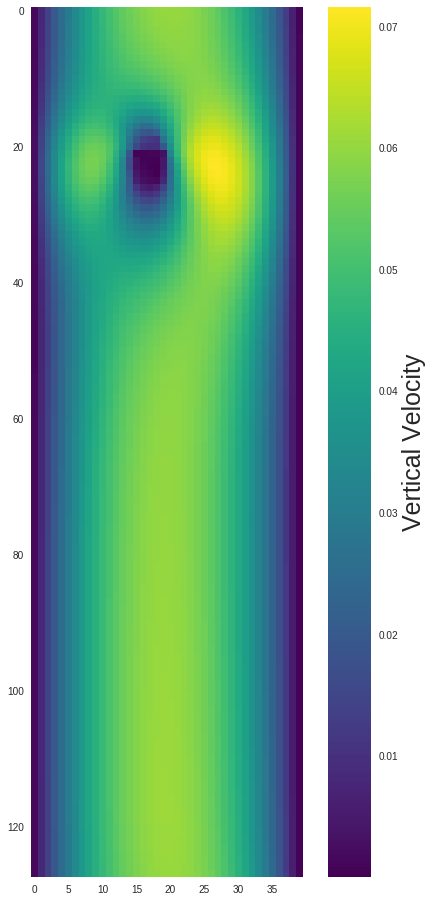

In [31]:
rho = calc_macro_f(a[-1])[1]
plt.figure(figsize=(9,16))
plt.imshow(np.fliplr(rho),cmap='viridis')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Vertical Velocity',fontsize=fs)
plt.grid('off')
plt.savefig(_SAVEDIR_+"box_boundary_result.png")


In [5]:
for i in range(0,Nsteps,5):
    plt.figure(figsize=(16,9))
    plt.imshow(flip_T(calc_macro_f(a[i])[1]))
    plt.grid('off')
    plt.colorbar()t
    plt.savefig('figures/obstacleU_'+str(i).zfill(5)+'.png')
    plt.close()

SyntaxError: invalid syntax (<ipython-input-5-d0635b2e2804>, line 5)

In [ ]:
rho = calc_macro_f(a[-1])[1]
plt.imshow(flip_T(rho))
plt.colorbar()
plt.grid('off')
plt.show()


In [ ]:
mpl.style.available